In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import scanpy as sc
import h5py
import sys

print(f'PID number is {os.getpid()}')

import matplotlib as mpl

figure_folder = r'figures'

mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=9.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=7.)
mpl.rc('axes', titlesize=8.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='svg')

mpl.rc('xtick', labelsize=6.5)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=0.5)

mpl.rc('ytick', labelsize=6.5)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=0.5)

mpl.rcParams['pdf.fonttype'] = 42

PID number is 17128


# Load DEG

In [2]:
df_deg = pd.read_csv(r'resources/Greenberg_scRNA_male_Mecp2_DEG_majortype.csv', index_col=0)

### clean up
df_deg = df_deg[df_deg['names']!='Mecp2'].copy() # remove Mecp2

df_deg.rename({'names':'gene', 'cell_type':'majortype'}, axis=1, inplace=True)

print(len(df_deg))

df_deg.head()

76894


,gene,scores,logfoldchanges,pvals,pvals_adj,majortype
1,Junb,-15.078729,-1.387881,6.169385e-49,7.800878e-46,Gluta
2,Arc,-14.795500,-1.546607,3.118615e-47,3.597041e-44,Gluta
3,Ctxn1,-13.829779,-0.598430,4.470588e-42,3.904597e-39,Gluta
4,Sepw1,-13.407591,-0.796429,1.258520e-39,9.360799e-37,Gluta
5,Dynll1,-13.161049,-0.553000,2.206324e-38,1.549881e-35,Gluta


In [3]:
### add Mecp2 effect

def get_Mecp2_effect(pval, log2fc, pval_thresh = 0.05):
    if pval>pval_thresh:
        return 'NE'
    elif log2fc>0:
        return 'Up-regulated'
    elif log2fc<0:
        return 'Down-regulated'
    else:
        return 'NE'

df_deg['Mecp2_effect'] = df_deg.apply(lambda x: get_Mecp2_effect(x['pvals_adj'], x['logfoldchanges']), axis=1)

# Load radial position

In [4]:
df_rp = pd.read_csv(r'resources/gene_rp_by_majortype.csv', index_col=0)
df_rp = df_rp[df_rp['radial_position']!=-1].copy()
df_rp.head()

,gene,chr,start,end,position,radial_position,majortype
0,0610006L08Rik,chr7,74818817,74853813,74836315.0,0.659868,Gluta
1,0610007P14Rik,chr12,85815447,85824550,85819998.5,0.678808,Gluta
2,0610009B22Rik,chr11,51685385,51688874,51687129.5,0.717041,Gluta
3,0610009E02Rik,chr2,26445695,26459390,26452542.5,0.615982,Gluta
4,0610009L18Rik,chr11,120348677,120351190,120349933.5,0.607882,Gluta


In [5]:
df_deg_with_rp = df_deg.merge(df_rp.loc[:,['gene','majortype','radial_position']], left_on=['gene','majortype'],
                             right_on=['gene', 'majortype'])

print(len(df_deg_with_rp))

df_deg_with_rp.head()

76535


,gene,scores,logfoldchanges,pvals,pvals_adj,majortype,Mecp2_effect,radial_position
0,Junb,-15.078729,-1.387881,6.169385e-49,7.800878e-46,Gluta,Down-regulated,0.689111
1,Arc,-14.795500,-1.546607,3.118615e-47,3.597041e-44,Gluta,Down-regulated,0.660645
2,Ctxn1,-13.829779,-0.598430,4.470588e-42,3.904597e-39,Gluta,Down-regulated,0.682432
3,Sepw1,-13.407591,-0.796429,1.258520e-39,9.360799e-37,Gluta,Down-regulated,0.571395
4,Dynll1,-13.161049,-0.553000,2.206324e-38,1.549881e-35,Gluta,Down-regulated,0.620983


# Plot DEG radial position by majortypes

In [6]:
sel_majortypes = ['Gluta', 'Oligo', 'Micro', 'Endo']

In [7]:
majorTypes = ['Gluta', 'Oligo', 'Micro', 'Endo']

### define function and interval for line plot
def get_upper_bound(all_values, bin_size=10):
    percentiles = np.arange(0,100, bin_size)
    percentiles = percentiles + bin_size
    upper_bound = []
    for p in percentiles:
        upper_bound.append(np.percentile(all_values, p))
    upper_bound = np.array(upper_bound)
    return upper_bound

dict_upper_bound_by_type = {}
for sel_type in majorTypes:
    dict_upper_bound_by_type[sel_type] = get_upper_bound(df_deg_with_rp[df_deg_with_rp['majortype']==sel_type]['radial_position'].values)
    
df_deg_with_rp['rp_interval'] = df_deg_with_rp.apply(lambda x: 
                                                     np.argmax(dict_upper_bound_by_type[x['majortype']]>=x['radial_position']),
                                            axis=1)

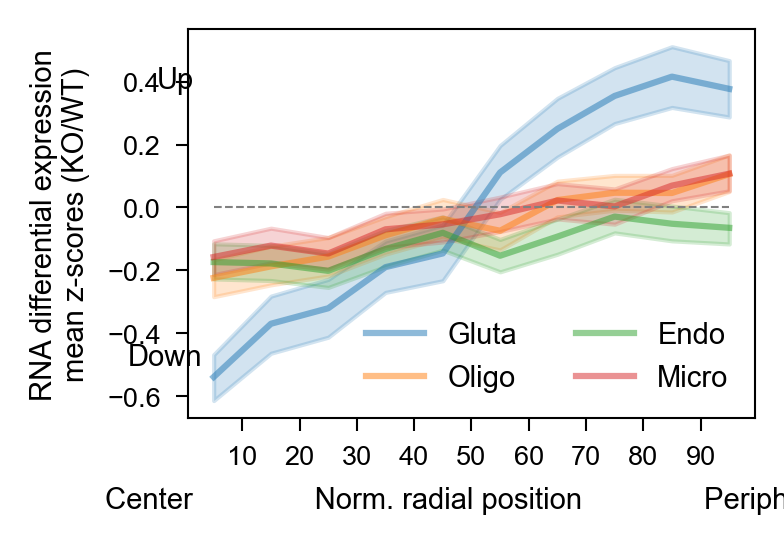

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


In [8]:
import seaborn as sns

fig = plt.figure(figsize=(2.5,1.7), dpi=300)

ax = fig.add_subplot(111)

df_plot = df_deg_with_rp[df_deg_with_rp.majortype.isin(sel_majortypes)].copy()
#df_plot = df_plot[(df_plot['pos_cell_frac']>=0.01)].copy()

sns.lineplot(data=df_plot, x='rp_interval', y='scores', hue='majortype', ax=ax, alpha=0.5)

ax.plot([0,9], [0,0], linewidth=0.5, color='gray', linestyle='--')

ax.set_ylabel('RNA differential expression\nmean z-scores (KO/WT)')
ax.set_xlabel('Center               Norm. radial position               Peripheral')
ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5],[10,20,30,40,50,60,70,80,90])

ax.text(-1.5, -0.5, 'Down', fontsize=7)
ax.text(-1, 0.38, 'Up', fontsize=7)

sns.move_legend(ax, loc='lower right', ncol=2, title=None, fontsize=7, frameon=False)
#plt.savefig('Mecp2_effect_by_Rp.pdf')
plt.show()

# Retrieve the color palette used
palette = sns.color_palette()

# Print out the palette values (as RGB tuples)
print(palette)

In [9]:
import numpy as np
import statsmodels.api as sm

slopes = []
lower_CIs = []
higher_CIs = []

for _type in majorTypes:
    df = df_plot[df_plot['majortype']==_type].copy()


    # Sample data
    X = df['radial_position'].values  # independent variable
    Y = df['scores'].values  # dependent variable

    # Add a constant for the intercept
    X_with_intercept = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(Y, X_with_intercept)
    results = model.fit()

    # Get the slope and confidence interval
    slope = results.params[1]
    conf_interval = results.conf_int(alpha=0.05)[1]  # 95% CI for the slope

    print(f"For cell type {_type}")
    print("Slope:", slope)
    print("95% Confidence Interval:", conf_interval)
    
    slopes.append(slope)
    lower_CIs.append(slope-conf_interval[0])
    higher_CIs.append(conf_interval[1]-slope)

For cell type Gluta
Slope: 4.1970624134710635
95% Confidence Interval: [3.84747862 4.5466462 ]
For cell type Oligo
Slope: 1.3945637914872508
95% Confidence Interval: [1.14281378 1.6463138 ]
For cell type Micro
Slope: 1.0922115569518926
95% Confidence Interval: [0.86496604 1.31945707]
For cell type Endo
Slope: 0.7806440551553762
95% Confidence Interval: [0.5126464  1.04864171]


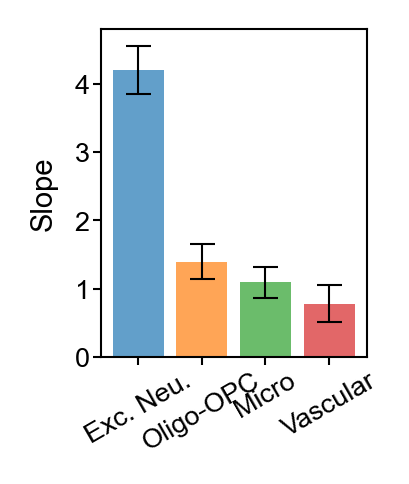

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Data
mean_values = slopes
lower_errors = lower_CIs  # Lower bound of the error
upper_errors = higher_CIs  # Upper bound of the error
x_labels = ['Exc. Neu.', 'Oligo-OPC', 'Micro', 'Vascular']
colors = palette[:4]

# Asymmetric error bars
error_bars = [lower_errors, upper_errors]

# Positions of bars on x-axis
x_pos = np.arange(len(mean_values))


fig = plt.figure(figsize=(1.25, 1.5), dpi=300)
ax = fig.add_subplot(111)
# Create the bar plot
ax.bar(x_pos, mean_values, yerr=error_bars, capsize=3, color=colors, alpha=0.7, 
       error_kw=dict(elinewidth=0.5,capthick=0.5))

# Add labels and title
ax.set_xlabel(None)
ax.set_ylabel('Slope', fontsize=7)
ax.set_ylim(0, 4.8)

# Customize x-axis labels
ax.set_xticks(x_pos, x_labels, fontsize=6.5)

ax.tick_params(axis='x', rotation=30)
ax.tick_params(axis='both', length=2, pad=0.6)

# Show plot
plt.show()
